In [1]:
import os
import re
import pandas as pd
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())

In [2]:
ETF = 'MSPUS'

https://fred.stlouisfed.org/series/MSPUS

In [3]:
month_mapping = {
    "Jun":6,
    "May":5,
    "Apr":4,
    "Mar":3,
    "Feb":2,
    "Jan":1,
    "Dec":12,
    "Nov":11,
    "Oct":10,
    "Sep":9,
    "Aug":8,
    "Jul":7,
    }

def date_normalize(date):
    try:
        result = re.search(r'(?P<m>\d+)\/(?P<d>\d+)\/(?P<y>\d+)', date).groupdict()
        output = '%04d-%02d-%02d'%(
            int(result['y']),
            int(result['m']),
            int(result['d']),
            )
        return output
    except:
        pass
    try:
        parsing_result = re.search(r'(?P<m>[A-z]{3}) (?P<d>\d{2}) (?P<y>\d{4})', date).groupdict()
        parsing_result['m'] = month_mapping[parsing_result['m']]
        parsing_result['m'] = '%02d'%(parsing_result['m'])
        return('%s-%s-%s'%(
            parsing_result['y'],
            parsing_result['m'],
            parsing_result['d'],
            ))
    except:
        pass
    return date

date = '9/17/2015'
date = 'Jun 14 2022'

date_normalize(
    date,
    )

'2022-06-14'

In [4]:
final_result = pd.read_csv(
    'history/{}.csv'.format(ETF),
    )

final_result['Date'] = final_result['Date'].apply(date_normalize)

final_result['Close'] = final_result['Close'].apply(lambda x: float(x))

final_result['id'] = final_result.index

<AxesSubplot:xlabel='Date'>

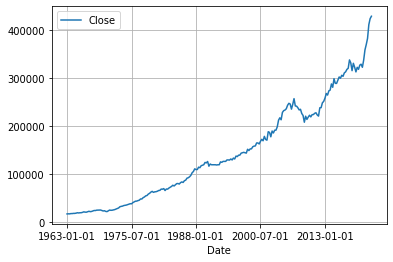

In [5]:
final_result.plot(x ='Date', y=[
    'Close', 
    ], grid = True)

In [6]:
final_result.head(10)

,Date,Close,id
0,1963-01-01,17800.0,0
1,1963-04-01,18000.0,1
2,1963-07-01,17900.0,2
3,1963-10-01,18500.0,3
4,1964-01-01,18500.0,4
5,1964-04-01,18900.0,5
6,1964-07-01,18900.0,6
7,1964-10-01,19400.0,7
8,1965-01-01,20200.0,8
9,1965-04-01,19800.0,9


In [7]:
quarter = 30
window_size = quarter*4

In [8]:
window_data = pysqldf(u"""
    select 
    now.Date as Last_Date, 
    now.Close as Last_Price,
    ago.Date as Start_Date,
    ago.Close as Start_Price,
    now.Close/ago.Close - 1.0 as Return_Rate
    from final_result as now
    join final_result as ago
    on ago.id = now.id - {}
    """.format(window_size))

In [9]:
window_data = pysqldf(u"""
    select *
    from window_data
    where Last_Date >= '2015-07-01'
    """)

<AxesSubplot:xlabel='Last_Date'>

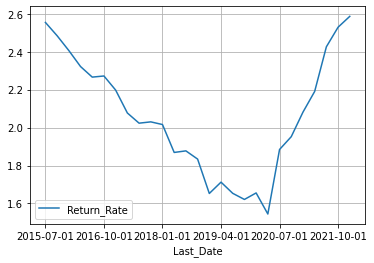

In [10]:
window_data.plot(x ='Last_Date', y=[
    'Return_Rate', 
    ], grid = True)

In [11]:
window_data.to_excel(
    'property_return_{}q.xlsx'.format(window_size),
    index = False)